In [1]:
from matplotlib import pyplot as plt
from matplotlib import patches
import numpy as np
import time
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN 
import cv2

In [2]:


def draw_coord(coord):
    plt.ion()
    for bbox in coord:
        fig,ax = plt.subplots(1,facecolor='white')
        for b in bbox:
            x1,y1,x2,y2 = b
            #rect=patches.Rectangle(xy=(x1,-y1),width=x2-x1,height=-(y2-y1),edgecolor='g', linewidth=3,fill=False)
            #ax.add_patch(rect)
            ax.scatter(x1+(x2-x1)/2,-y2)
            plt.ylim((-500,0))
            plt.xlim((0,600))
        
    

In [62]:
def densest(points,cluster_label,n=1):
    dic = {}
    for i,pts in enumerate(points):
        if cluster_label[i] not in dic.keys():
            dic[cluster_label[i]] = [pts]
        else:
            dic[cluster_label[i]] += [pts]
    mean_ = [np.mean(dic[key],axis=0) for key in dic.keys()]
    cluster_dist = []

#     for i,(key,val) in enumerate(dic.items()):
#         assert len(val) > 0
#         temp = np.sum(np.sqrt(np.sum((val - mean_[i])**2,axis=1)))*(1/np.exp(len(val))) #penalize cluster with lesser points
#         if i == 0:
#             min_ = temp
#             densest = key
#         if temp < min_:
#             min_ = temp
#             densest = key
    output = []
    for i,(key,val) in enumerate(dic.items()):
        assert len(val) > 0
        output += [(np.sum(np.sqrt(np.sum((val - mean_[i])**2,axis=1)))*(1/np.exp(len(val))) , key)] #penalize cluster with lesser points
    print(output)
    output = sorted(output, key=lambda tup:tup[0])[:n]
    print("after sorted",output)
    densest_key = [tup[1] for tup in output]
    
    
#     return (cluster_label == densest).astype(int)
    return np.array([i  if i in densest_key else 0 for i in cluster_label])
    
    
    

def in_out_frame(coord):
    enterring = []
    leaving = []
    existed_id = [i[1] for i in coord[0]] #the first frame,all existed id ids 


    for k,z in enumerate(coord):
        new_frame_id =[i[1] for i in z]
        enterring += [z[i] for i,j in enumerate(new_frame_id) if j not in existed_id]
        leaving += [coord[k-1][i] for i,j in enumerate(existed_id) if j not in new_frame_id]
#         existed_id += new_frame_id
        existed_id = new_frame_id
    return [enterring, leaving]

In [64]:
def scatter_in_out(enter=None,leave=None,title='Camera detection',processed_entry=None,save=False):
    fig,ax = plt.subplots(1,facecolor='white')
    
#     kmeans = KMeans(n_clusters=2)
    
#     y_kmeans = kmeans.predict(X)
    if enter is not None:
        en = np.array([[coor[0]+(coor[2] - coor[0]),-coor[3]] for coor in [n[0] for n in enter]])
#         kmeans.fit(en)
        db = DBSCAN(eps=50, min_samples=3).fit(en) 
        ax.scatter(en[:,0],en[:,1],c=densest(en,db.labels_))
#     ax.scatter(processed_entry[0],processed_entry[1],c='black')
    if leave is not None:
        lea = np.array([[coor[0]+(coor[2] - coor[0]),-coor[3]] for coor in [n[0] for n in leave]])
        db = DBSCAN(eps=50, min_samples=3).fit(lea) 
        ax.scatter(lea[:,0],lea[:,1],c=densest(lea,db.labels_)+2)
    plt.ylim((-500,0))
    plt.xlim((0,600))
    plt.title(title)
    if save==True:
        plt.savefig("/home/chunhung/tracking/{}.png".format(title))
#     if (enter is not None )&  (leave is not None):
#         return en,lea
# #     elif (enter is not None )&  (leave is None):
      
# #         return en
#     else:
#         return en
    return en,db.labels_
    

IndexError: invalid index to scalar variable.

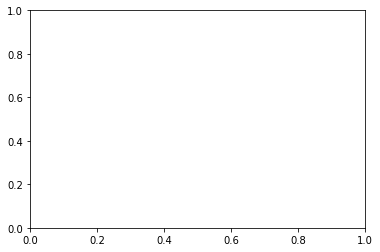

In [55]:

scatter_in_out([arr[0] for arr in out[0]]+[arr[0] for arr in out[1]])

[(0.7007928949796526, -1), (0.4313028787399464, 0), (4.746984072853061, 1)]
after sorted [(0.4313028787399464, 0)]


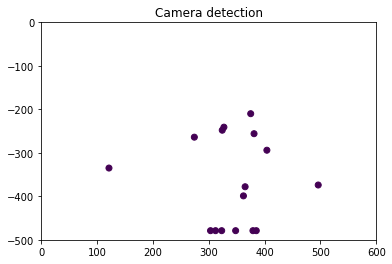

In [66]:
en,label = scatter_in_out(enter=out[0])

In [69]:
densest(en,label)

[(0.7007928949796526, -1), (0.4313028787399464, 0), (4.746984072853061, 1)]
after sorted [(0.4313028787399464, 0)]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

[(7.504850917603622, -1)]
after sorted [(7.504850917603622, -1)]
[(0.0014828543375563009, 0), (2.300699815022416, -1), (2.5552073270031643, 1)]
after sorted [(0.0014828543375563009, 0)]
[(0.6104212348753204, 0), (4.692849477953255, -1)]
after sorted [(0.6104212348753204, 0)]
[(0.7007928949796526, -1), (0.4313028787399464, 0), (4.746984072853061, 1)]
after sorted [(0.4313028787399464, 0)]


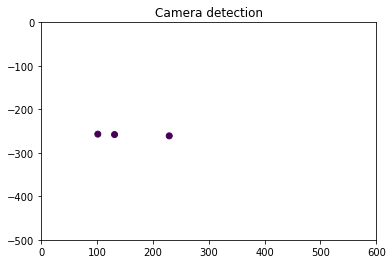

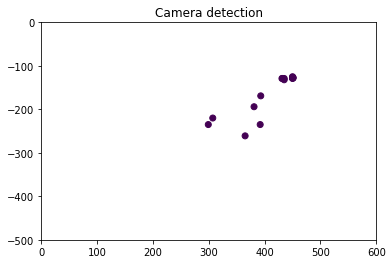

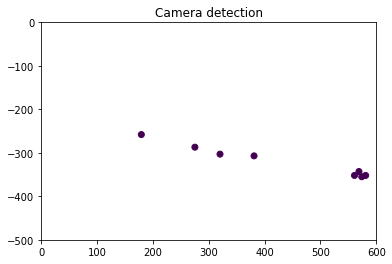

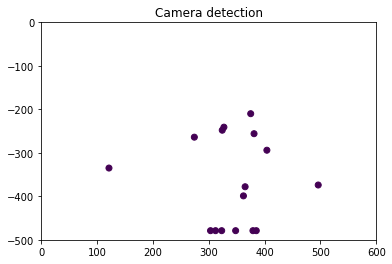

In [63]:
scene = 8

for cam in range(1,5):
    coord = np.load("/home/chunhung/tracking/cam{}_0{}.npy".format(cam,scene),allow_pickle=True)
    out = in_out_frame(coord)
#     en = scatter_in_out([arr[0] for arr in out[0]]+[arr[0] for arr in out[1]],title=f'Camera {cam} scene {scene}',save=False)
    en = scatter_in_out(enter=out[0])

In [27]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
hough(en)

ModuleNotFoundError: No module named 'skimage'

1. if we have line dots or cluster or dots that close to border , how should we give more weights, what if entry point and exit point are not around border.

1.2 Need to differentiate entry point and the angle where model always re tracking (kinda done)

2. Bayesian inference on the a bbox close to the exit or entry cluster

3. is there an algo that put focus on cluster power (kinda done)

4. if border are entry, can try matching points from dbscan and hough line, if most of the points are on line

5. do we assume there are only two ways in frame, meaning two borders for in and out

    thoughts so far:

Use features to recognise same person from different cameras can be unstable. HOG maybe feasible.
FOV can only solve the handoff problem. Proceed for that.
Find handoff data

how to link all cameras together. passing common information

is it necessary to let cameras in the same scene to sync the same person

should the tracking to different camera process be offline or ad hoc


In [ ]:
#track houseattack , for border?

In [112]:
houseattack =np.load("/home/chunhung/tracking/houseattack.npy",allow_pickle=True)

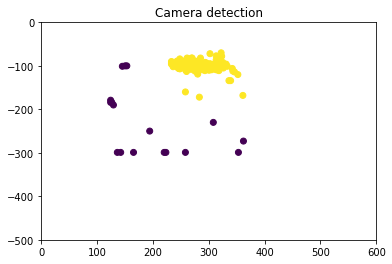

In [144]:
out = in_out_frame(houseattack)
scatter_in_out(enter=out[0])

# Homography

In [352]:
def homography_mat(cam1,cam2):
    mat = np.array([])
  
    assert len(cam1) == len(cam2)
    for i in range(len(cam1)):
        c1 = cam1[i]
        c2 = cam2[i]
        row = np.array([[c2[0],c2[1], 1,0,0,0,-1*c2[0]*c1[0], -1*c1[0]*c2[1]],
                       [0,0,0, c2[0],c2[1], 1, -1*c2[0]*c1[1], -1*c1[1]*c2[1]]
                       ])

        if i ==0 :
            mat = row
            b = c1
        else:
            mat = np.append(mat,row, 0)
            b = np.append(b,c1)

    h_man = np.dot(np.linalg.inv(np.dot(mat.T,mat)),np.dot(mat.T,b))
    h_man = np.reshape(np.append(h_man,1),(3,3))

    
    return h_man

def homography_mat2(cam1,cam2):
    mat = np.array([])

    assert len(cam1) == len(cam2)
    for i in range(len(cam1)):
#         c1 = cam1[i]
#         c2 = cam2[i]
#         row = np.array([[c2[0],c2[1], 1,0,0,0,-1*c2[0]*c1[0], -1*c1[0]*c2[1]],
#                        [0,0,0, c2[0],c2[1], 1, -1*c2[0]*c1[1], -1*c1[1]*c2[1]]
#                        ])

#         if i ==0 :
#             mat = row
#             b = c1
#         else:
#             mat = np.append(mat,row, 0)
#             b = np.append(b,c1)
        c1 = cam1[i]
        c2 = cam2[i]
        row = np.array([[c2[0],c2[1], 1,0,0,0,-1*c2[0]*c1[0], -1*c1[0]*c2[1], -c1[0]],
                       [0,0,0, c2[0],c2[1], 1, -1*c2[0]*c1[1], -1*c1[1]*c2[1], -c1[1]]
                       ])
        if i ==0:
            mat = row
        else:
            mat = np.append(mat,row,0)
            
#     h_man = np.dot(np.linalg.inv(np.dot(mat.T,mat)),np.dot(mat.T,b))
#     h_man = np.reshape(np.append(h_man,1),(3,3))
    u,d,v = np.linalg.svd(np.dot(mat.T,mat))
    h = np.reshape(u[-1],(3,3))
    
    return mat,u,d,v


def to_camera_coord(pts,h):

    homog = np.dot(h,np.append(pts,[1]))
    homog = homog / homog[-1]
    return homog[:-1].astype('uint32')

def to_camera_box(bbox_coord,h):
    assert len(bbox_coord) ==4
    (x1,y1) = to_camera_coord(bbox_coord[:2],h)
    (x2,y2) = to_camera_coord(bbox_coord[2:],h)
    return np.array([x1,y1,x2,y2])


In [337]:
temp = homography_mat2(pts_src,pts_dst)
np.dot(temp[0],temp[1])

array([10111.23299364,  2388.2937525 ,  9634.79279183,  2274.91922868,
        9351.34731406,  2255.72374791,  8651.22411077,  2030.16894885,
        8134.6356604 ,  1979.43180376,  7756.40062037,  1893.07221571,
        7328.1534518 ,  1990.25221855,  7443.04942895,  2026.36137186,
        7463.6925156 ,  2009.33277279,  7303.70209981,  2117.7416046 ,
        7155.46210519,  2144.04218745,  6965.46961326,  2096.24066187,
        6612.28591556,  2056.02475214,  6530.04904512,  2128.69317995,
        6452.63159267,  2178.80031572,  6403.00438183,  2300.82723009,
        6296.5257395 ,  2337.34009866,  6204.29379805,  2317.37971025,
        6144.13686217,  2463.70483452,  5953.14477961,  2337.38899363,
        5913.95811446,  2204.90324808,  5988.72485971,  2214.33571919,
        6000.76245753,  2236.33327484,  5921.84951166,  2408.89489406,
        5829.8707447 ,  2410.53351752,  5526.93974448,  2549.66061291,
        5098.00609674,  2515.64156633,  4737.67297388,  2486.54293116,
      

In [387]:
np.cos(30)

0.15425144988758405

In [397]:

orig = [1,0]
trans = []
trans = trans + [orig]

for i in range(20):
    trans += [[orig[0]*np.cos(10),orig[0]*np.sin(10)]]
    orig = [orig[0]*np.cos(10),orig[0]*np.sin(10)]


In [386]:
cv2.imshow('test',[[1,1,-1],[255,255,1],[0,0,0]])
cv2.waitKey(1)

TypeError: Expected Ptr<cv::UMat> for argument 'mat'

In [447]:
rot_mat = np.array(
    [[np.cos(deg *np.pi/180) , np.sin(deg *np.pi/180)],
     [-np.sin(deg *np.pi/180) , np.cos(deg *np.pi/180)]]
    
)

In [448]:
collect = []
x = [5,5]
deg = 10
for i in range(30):
    collect += [np.dot(rot_mat,x)]
    x = np.dot(rot_mat,x)

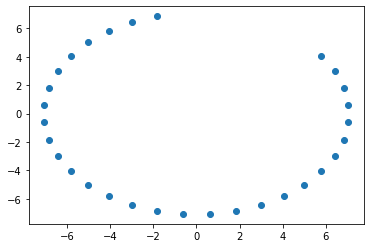

In [449]:
plt.scatter(np.array(collect)[:,0],np.array(collect)[:,1])

In [469]:
np.eye(4, 2 * 4)


array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]])

In [973]:
pts_dst1,pts_src1 = np.load('npy/pts_cam203.npy')

In [974]:
pts_dst2,pts_src2 = np.load('npy/pts_cam2_02.npy')

In [975]:
pts_dst = np.append(pts_dst1,pts_dst2,axis=0)
pts_src = np.append(pts_src1,pts_src2,axis=0)

In [976]:
temp = list(range(0,len(pts_dst)))
np.random.shuffle(temp)

In [977]:
pts_dst = pts_dst[temp][:int(len(pts_dst)*1),:]
pts_src = pts_src[temp][:int(len(pts_src)*1),:]

In [609]:
np.save('npy/weights_cam1_2.npy',cv2.findHomography(pts_dst,pts_src)[0])

In [978]:
h = cv2.findHomography(pts_src,pts_dst)[0]

In [95]:
def affine(frame,h):
    mat =h

    size = frame.shape
    new_frame = np.zeros((size[0],size[1],3))
    #new_frame = np.zeros((int(2*(np.sqrt((size[0]/2)**2 + size[1]/2)**2 + 5)) , int(2*(np.sqrt((size[0]/2)**2 + size[1]/2)**2 +5)),3))
    for i in range(len(frame)):
        for j in range(len(frame[i])):
            try:
                new_coord = np.dot(mat,np.array([i,j,1]))
                new_coord = new_coord/new_coord[-1]
                new_frame[int(new_coord[0]),int(new_coord[1]),:] = frame[i][j]
            except:
                pass


    return new_frame.astype('uint8')


def homo(pts,h):
    pts = np.append(pts,[1])
    new = np.dot(h,pts)
    new = new / new[-1]
    return new[:-1]


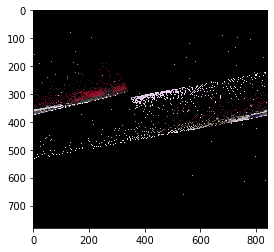

In [979]:
plt.imshow(affine(scene,h))

In [88]:

small_rec = np.array([[140,250],[140,300],[180,300],[180,250],[140,250]])

In [91]:
def homo(pts,h):
    pts = np.append(pts,[1])
    new = np.dot(h,pts)
    new = new / new[-1]
    return new[:-1]

small_rec_proj = []
small_rec_proj_inv = []
for arr in small_rec:
    small_rec_proj += [homo(arr,h)]
#     small_rec_proj_inv += [homo(homo(arr,h),np.linalg.inv(h))]    
small_rec_proj = np.array(small_rec_proj)
small_rec_proj_inv = np.array(small_rec_proj_inv)

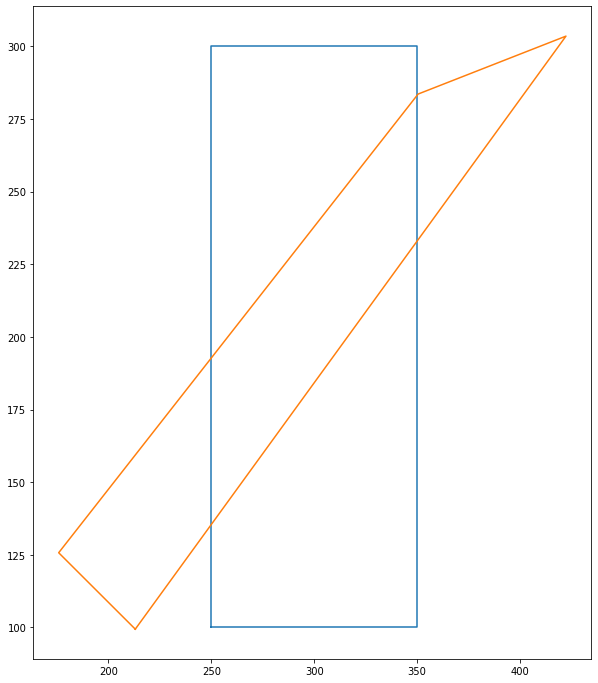

In [740]:
plt.figure(figsize=(10,12))
plt.plot(rec[:,0],rec[:,1])
# plt.plot(small_rec[:,0],small_rec[:,1],color='black',lw=5)
plt.plot(small_rec_proj[:,0],small_rec_proj[:,1])
# plt.plot(small_rec_proj_inv[:,0],small_rec_proj_inv[:,1],color='yellow')

In [ ]:
plt.figure(figsize=(10,12))
# plt.scatter(rec[:,0],rec[:,1])
plt.plot(small_rec[:,0],small_rec[:,1],color='black',lw=5)
plt.plot(small_rec_proj[:,0],small_rec_proj[:,1])
plt.plot(small_rec_proj_inv[:,0],small_rec_proj_inv[:,1],color='yellow')

In [ ]:
# plt.figure(figsize=(8,8))

# plt.imshow(cv2.GaussianBlur(scene,(5,5),1.6),cmap='gray')


def per_octave(scene):

    scale_in_octave = []
    sigma = 1.6
    k = np.sqrt(2)

    for i in range(5):
        scale_in_octave += [cv2.GaussianBlur(scene,(5,5),sigma)]
        sigma = k*sigma

    dog = []
    for i in range(len(scale_in_octave) - 1):
        dog += [scale_in_octave[i] - scale_in_octave[i+1]]
    return dog




# sift , image stitching

In [2]:
# scene_col = cv2.imread('/home/chunhung/tracking/feeds/lab/cam1/000002/002370.jpg')
# scene2_col = cv2.imread('/home/chunhung/tracking/feeds/lab/cam2/000002/002360.jpg')

scene_col = cv2.imread('/home/chunhung/tracking/white_choc_stitch.jpg')
scene2_col = cv2.imread('/home/chunhung/tracking/white_choc_stitch1.jpg')

# scene_col = cv2.imread('feeds/lab/cam1/000000/000021.jpg')
# scene2_col = cv2.imread('feeds/lab/cam2/000000/000021.jpg')
scene = cv2.resize(scene_col,(600,800))
scene2 = cv2.resize(scene2_col,(600,800))
scene_col = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
scene2_col = cv2.cvtColor(scene2, cv2.COLOR_BGR2RGB)

scene = cv2.cvtColor(scene, cv2.COLOR_BGR2GRAY)
scene2 = cv2.cvtColor(scene2, cv2.COLOR_BGR2GRAY)



# scene = scene[:,:,0]*0.4 + scene[:,:,1]*0.4 + scene[:,:,2]*0.3

In [3]:
laplacian = cv2.Laplacian(scene,cv2.CV_64F)

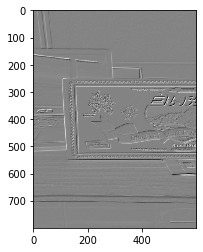

In [302]:
sobelx = cv2.Sobel(scene,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(scene,cv2.CV_64F,0,1,ksize=5)
plt.imshow(sobely+sobelx,cmap='gray')

In [4]:

sift = cv2.xfeatures2d.SIFT_create()
img1 = scene
img2 = scene2
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

In [5]:

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

In [6]:
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append(m)

In [7]:
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(dst_pts,src_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = scene2.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

#     img1 = cv2.polylines(img1,[np.int32(dst)],True,255,3, cv2.LINE_AA)
#     img1 = cv2.warpPerspective(img1,M,dsize=(img1.shape[0],img1.shape[1]))
else:
    print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

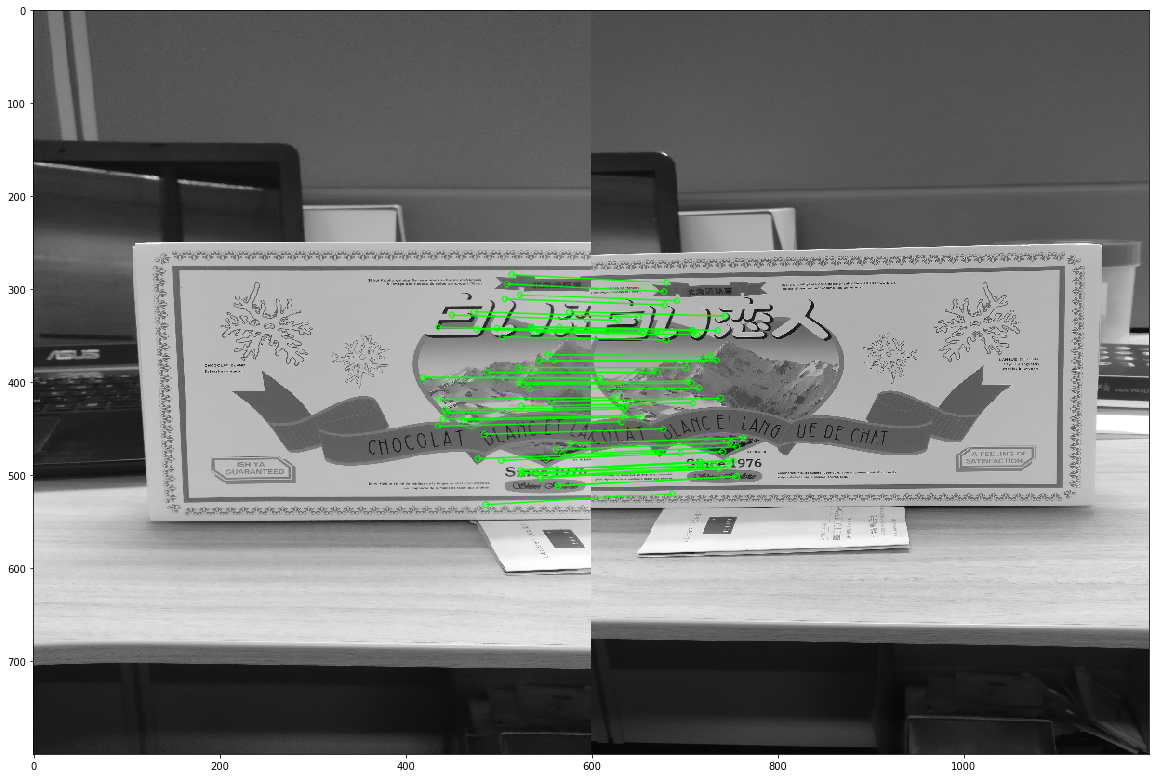

In [8]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize=(20,20))
plt.imshow(img3, 'gray')

In [11]:
from matplotlib import patches

def affine(frame,h):
    mat =h

    size = frame.shape
    new_frame = np.zeros((size[0],size[1],3))
    #new_frame = np.zeros((int(2*(np.sqrt((size[0]/2)**2 + size[1]/2)**2 + 5)) , int(2*(np.sqrt((size[0]/2)**2 + size[1]/2)**2 +5)),3))
    for i in range(len(frame)):
        for j in range(len(frame[i])):
            try:
                new_coord = np.dot(mat,np.array([i,j,1]))
                new_coord = new_coord/new_coord[-1]
                new_frame[int(new_coord[0]),int(new_coord[1]),:] = frame[i][j]
            except:
                pass


    return new_frame.astype('uint8')


def homo(pts,h):
    pts = np.append(pts,[1])
    new = np.dot(h,pts)
    new = new / new[-1]
    return new[:-1]


def pad_bottom(im,rows):
    temp = np.zeros((im.shape[0]+rows,im.shape[1],im.shape[-1]),dtype='uint8')
    temp[:im.shape[0],:im.shape[1],:] = im
    return temp


def pad_right(im,cols):
    temp = np.zeros((im.shape[0],im.shape[1]+cols,im.shape[-1]),dtype='uint8')
    temp[:im.shape[0],:im.shape[1],:] = im
    return temp

def pad_left(im,cols):
    temp = np.zeros((im.shape[0],im.shape[1]+cols,im.shape[-1]),dtype='uint8')
    temp[:im.shape[0],cols:,:] = im
    return temp


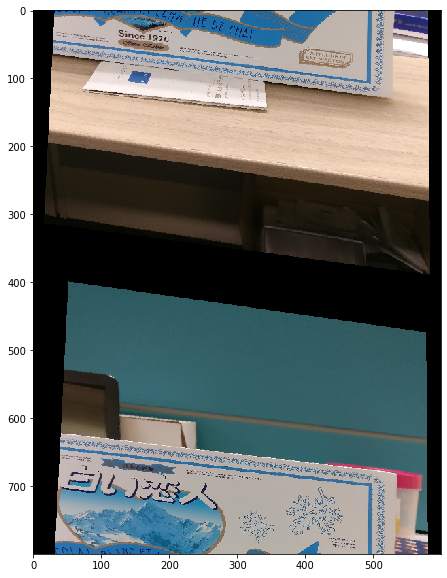

In [12]:
plt.figure(figsize=(10,10))
im  =affine(scene2_col,np.linalg.inv(M))
T = np.float32([[1, 0, 0], [0, 1, -200]]) 
cv2.warpAffine(im,T,(im.shape[1],im.shape[0]))


plt.imshow(im)

# rec = np.array([[390,520],[405,560],[420,520],[400,490],[390,520]])
# plt.plot(rec[:,0],rec[:,1])

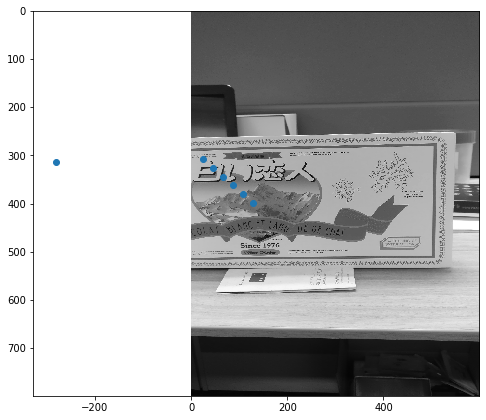

In [64]:
plt.figure(figsize=(8,8))
plt.imshow(scene2,cmap='gray')
trans_pts = np.array([homo(arr,np.linalg.inv(M)) for arr in rec])
plt.scatter(trans_pts[:,0],trans_pts[:,1])

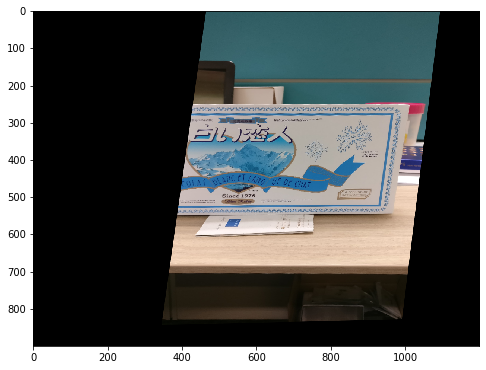

In [134]:
plt.figure(figsize=(8,8))
# plt.imshow(affine(scene2,np.linalg.inv(M)))
plt.imshow(cv2.warpPerspective(scene2_col,M,dsize=(scene2_col.shape[0]+400,scene2_col.shape[1]+300)))

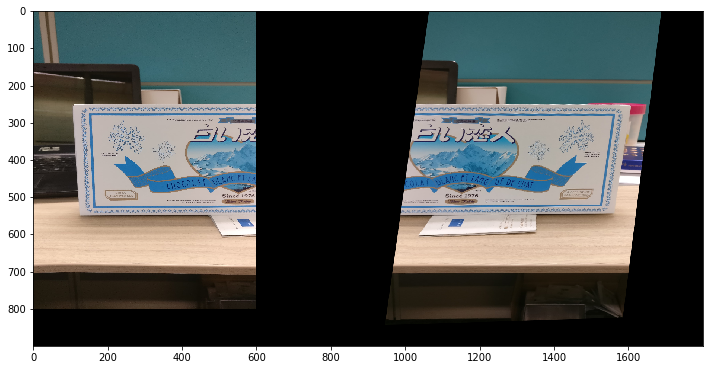

In [13]:
plt.figure(figsize=(12,12))

pers_scene2_col = cv2.warpPerspective(scene2_col,M,dsize=(scene2_col.shape[0]+400,scene2_col.shape[1]+300))
pad_w  = pers_scene2_col.shape[1] - scene_col.shape[1]
pad_h  = pers_scene2_col.shape[0] - scene_col.shape[0]

# plt.imshow(np.concatenate([scene_col,affine(scene2_col,np.linalg.inv(M))],axis=1),cmap='gray')

plt.imshow(np.concatenate([pad_bottom(scene_col,pad_h),pers_scene2_col],axis=1),cmap='gray')

In [118]:
def blend(left,right,inters):
    left_h,left_w,left_fil = left.shape
    right_h,right_w,right_fil = right.shape
    assert left_h == right_h
#     for x in range(left_w-1,0,-1):
#         if homo()

    temp = np.zeros((left_h,left_w+right_w - inters,3),dtype='int16')
    temp[:left_h,:left_w,:] = left
    temp[:left_h,left_w-inters:,:] += right
    
    
    for i in range(temp.shape[1]):
        if ((temp>255)[:,i,:] == False).all() == False:
            break
            
    alpha1 = 0.
    alpha2 = 0.6
    
    temp[:,i:left_w,:] = (right[:,:inters-i,:] * alpha1 + left[:,i:,:] * alpha2)/(alpha1+alpha2)

    return temp.astype('uint8')
    

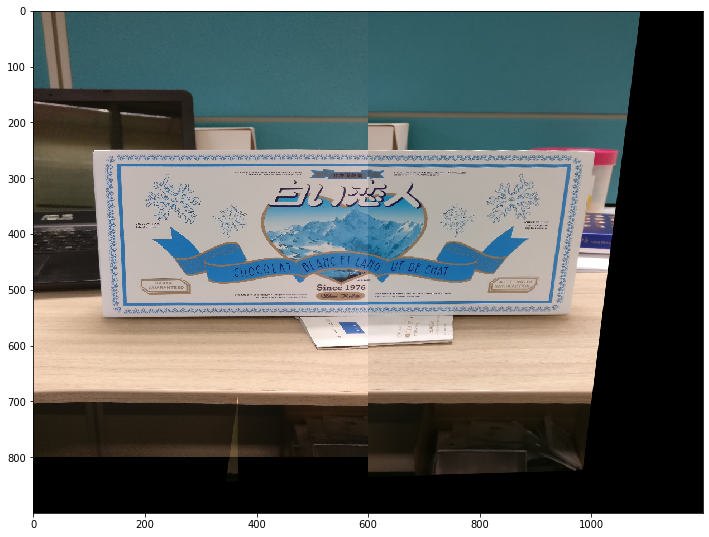

In [119]:
plt.figure(figsize=(12,12))
plt.imshow(blend(pad_bottom(scene_col,pad_h),pers_scene2_col,600))

In [4]:
scene = cv2.imread('/home/chunhung/tracking/feeds/lab/cam1/000002/002370.jpg')
scene2 = cv2.imread('/home/chunhung/tracking/feeds/lab/cam2/000002/002360.jpg')



# scene = cv2.imread('feeds/lab/cam1/000000/000021.jpg')
# scene2 = cv2.imread('feeds/lab/cam2/000000/000021.jpg')
scene = cv2.resize(scene,(600,600))
scene2 = cv2.resize(scene2,(600,600))
scene_col = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
scene2_col = cv2.cvtColor(scene2, cv2.COLOR_BGR2RGB)

scene = cv2.cvtColor(scene_col, cv2.COLOR_BGR2GRAY)
scene2 = cv2.cvtColor(scene2_col, cv2.COLOR_BGR2GRAY)



# scene = scene[:,:,0]*0.4 + scene[:,:,1]*0.4 + scene[:,:,2]*0.3

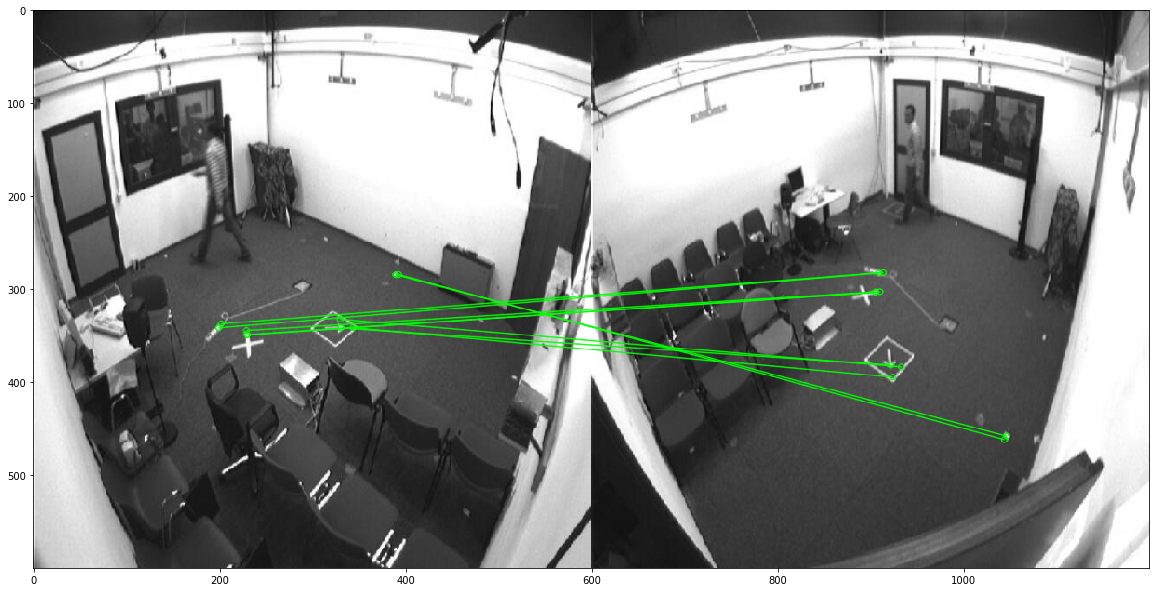

In [369]:

sift = cv2.xfeatures2d.SIFT_create()
img1 = scene
img2 = scene2
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)


FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append(m)
        
        
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(dst_pts,src_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = scene2.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

#     img1 = cv2.polylines(img1,[np.int32(dst)],True,255,3, cv2.LINE_AA)
#     img1 = cv2.warpPerspective(img1,M,dsize=(img1.shape[0],img1.shape[1]))
else:
    print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None
    
    
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize=(20,20))
plt.imshow(img3, 'gray')

# Project on floor plane

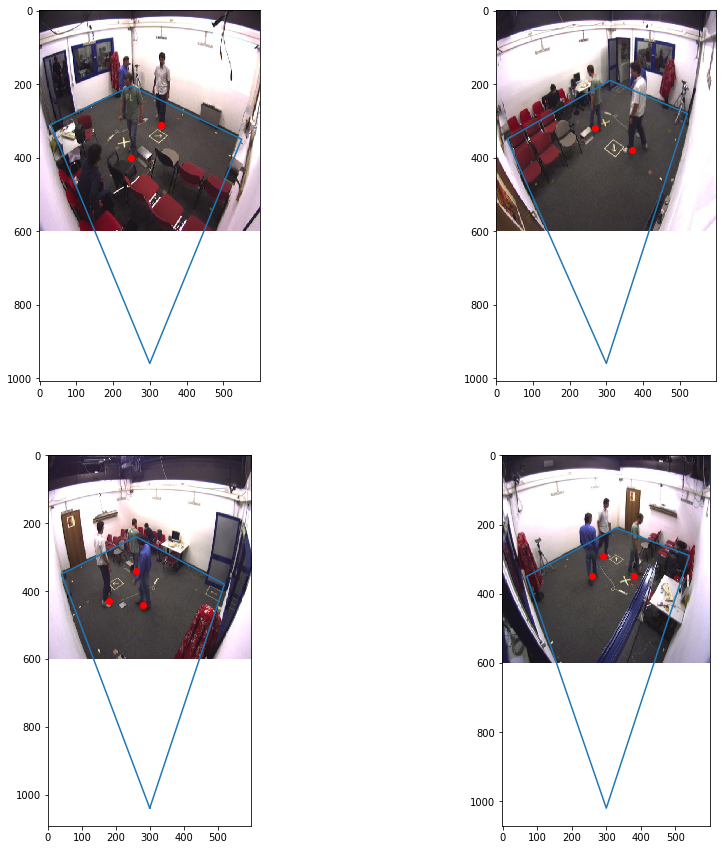

In [332]:
scene = cv2.imread('/home/chunhung/tracking/feeds/lab/cam1/000009/009091.jpg')
scene2 = cv2.imread('/home/chunhung/tracking/feeds/lab/cam2/000009/009061.jpg')
scene3 = cv2.imread('/home/chunhung/tracking/feeds/lab/cam3/000009/009031.jpg')
scene4 = cv2.imread('/home/chunhung/tracking/feeds/lab/cam4/000009/009001.jpg')

scene = cv2.resize(scene,(600,600))
scene2 = cv2.resize(scene2,(600,600))
scene3 = cv2.resize(scene3,(600,600))
scene4 = cv2.resize(scene4,(600,600))

scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
scene2 = cv2.cvtColor(scene2, cv2.COLOR_BGR2RGB)
scene3 = cv2.cvtColor(scene3, cv2.COLOR_BGR2RGB)
scene4 = cv2.cvtColor(scene4, cv2.COLOR_BGR2RGB)


fig,ax = plt.subplots(2,2,figsize=(15,15))
dst = np.array([[100,100],[100,500],[500,500],[500,100]])



ax[0,0].imshow(scene,cmap='gray')
rec1 = np.array([[250,205],[30,310],[300,960],[550,350],[250,205]])
loc1 = np.array([[250,400],[330,310]])
ax[0,0].plot(rec1[:,0],rec1[:,1])
ax[0,0].scatter(loc1[:,0],loc1[:,1],color='red')

y = [arr[1] for arr in rec1]
vp1 = y.index(max(y))



ax[0,1].imshow(scene2,cmap='gray')
rec2 = np.array([[520,280],[310,190],[30,350],[300,960],[520,280]])
ax[0,1].plot(rec2[:,0],rec2[:,1])
loc2 = np.array([[270,320],[370,380]])
ax[0,1].scatter(loc2[:,0],loc2[:,1],color='red')

y = [arr[1] for arr in rec2]
vp2 = y.index(max(y))



ax[1,0].imshow(scene3,cmap='gray')
rec3 = np.array([[300,1040],[520,380],[260,240],[40,350],[300,1040]])
ax[1,0].plot(rec3[:,0],rec3[:,1])
loc3 = np.array([[260,340],[180,430],[280,440]])
ax[1,0].scatter(loc3[:,0],loc3[:,1],color='red')

y = [arr[1] for arr in rec3]
vp3 = y.index(max(y))




ax[1,1].imshow(scene4,cmap='gray')
rec4 = np.array([[70,350],[300,1020],[540,290],[330,210],[70,350]])
ax[1,1].plot(rec4[:,0],rec4[:,1])
loc4 = np.array([[380,350],[290,290],[260,350]])
ax[1,1].scatter(loc4[:,0],loc4[:,1],color='red')

y = [arr[1] for arr in rec4]
vp4 = y.index(max(y))



In [334]:
M1= cv2.findHomography(rec1[:-1],dst)[0]
M2= cv2.findHomography(rec2[:-1],dst)[0]
M3= cv2.findHomography(rec3[:-1],dst)[0]
M4= cv2.findHomography(rec4[:-1],dst)[0]

trans_loc1 = np.array([homo(arr,M1) for arr in loc1])
trans_loc2 = np.array([homo(arr,M2) for arr in loc2])
trans_loc3 = np.array([homo(arr,M3) for arr in loc3])
trans_loc4 = np.array([homo(arr,M4) for arr in loc4])

trans_rec1 = np.array([homo(arr,M1) for arr in rec1])
trans_rec2 = np.array([homo(arr,M2) for arr in rec2])
trans_rec3 = np.array([homo(arr,M3) for arr in rec3])
trans_rec4 = np.array([homo(arr,M4) for arr in rec4])

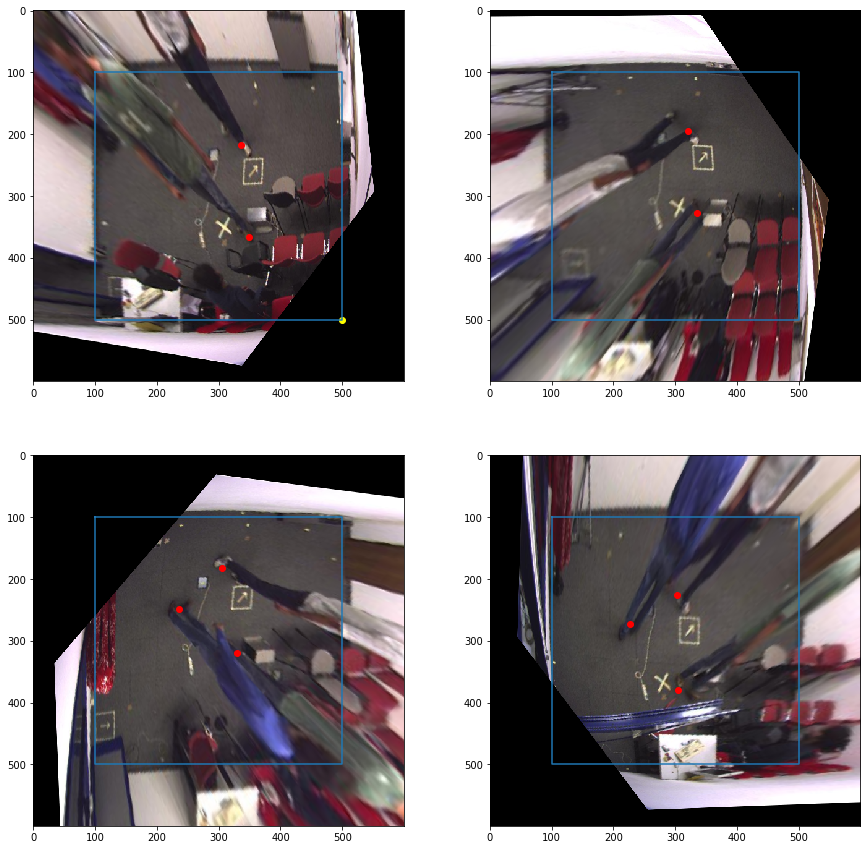

In [335]:
fig,ax = plt.subplots(2,2,figsize=(15,15))

ax[0,0].imshow(cv2.warpPerspective(scene,M1,dsize=(scene.shape[0],scene.shape[1])),cmap='gray')
ax[0,0].scatter(trans_loc1[:,0],trans_loc1[:,1],color='red')
ax[0,0].plot(trans_rec1[:,0],trans_rec1[:,1])
ax[0,0].scatter(trans_rec1[vp1,0],trans_rec1[vp1,1],color='yellow')

ax[0,1].imshow(cv2.warpPerspective(scene2,M2,dsize=(scene2.shape[0],scene2.shape[1])),cmap='gray')
ax[0,1].scatter(trans_loc2[:,0],trans_loc2[:,1],color='red')
ax[0,1].plot(trans_rec2[:,0],trans_rec2[:,1])

ax[1,0].imshow(cv2.warpPerspective(scene3,M3,dsize=(scene3.shape[0],scene3.shape[1])),cmap='gray')
ax[1,0].scatter(trans_loc3[:,0],trans_loc3[:,1],color='red')
ax[1,0].plot(trans_rec3[:,0],trans_rec3[:,1])

ax[1,1].imshow(cv2.warpPerspective(scene4,M4,dsize=(scene4.shape[0],scene4.shape[1])),cmap='gray')
ax[1,1].scatter(trans_loc4[:,0],trans_loc4[:,1],color='red')
ax[1,1].plot(trans_rec4[:,0],trans_rec4[:,1])

In [204]:
all_trans_loc = []
sample_pts = np.empty((0,2))
for l in [trans_loc1,trans_loc2,trans_loc3,trans_loc4]:
    sample_pts = np.append(sample_pts,l,axis=0)
    all_trans_loc += [l]

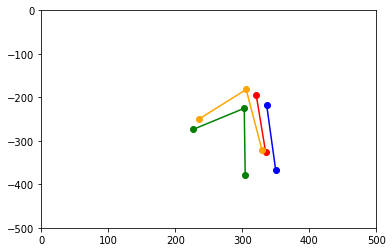

In [223]:
plt.xlim(0,500)
plt.ylim(-500,0)
cl = np.array(['blue','red','orange','green','yellow'])
for i in range(len(all_trans_loc)):
    plt.plot(all_trans_loc[i][:,0],all_trans_loc[i][:,1]*-1,color=cl[i],marker='o')

In [224]:

clustering = DBSCAN(eps=50, min_samples=1).fit(sample_pts)
#need algo to restrict number of elements in cluster < number of cam views

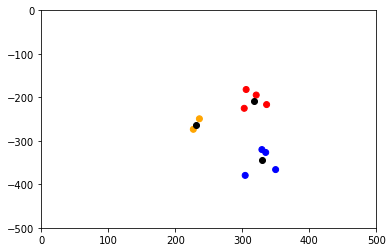

In [468]:
plt.xlim(0,500)
plt.ylim(-500,0)
plt.scatter(sample_pts[:,0],sample_pts[:,1]*-1,color=cl[clustering.labels_])

cluster_mean = np.empty((0,2))
for ele in set(clustering.labels_):
    
    cluster_mean = np.append(cluster_mean,np.expand_dims(np.mean(sample_pts[clustering.labels_ == ele,:],axis=0),0),axis=0)

cluster_ = cluster([viewpt1,viewpt2,viewpt3,viewpt4])
plt.scatter(cluster_[:,0],cluster_[:,1]*-1,color='black')
# plt.scatter(cluster_mean[:,0],cluster_mean[:,1]*-1,color='black')

In [459]:
class Viewpoint:
    '''Called from drawing space boundary'''
    
    
    def __init__(self,boundary):
        self.box = boundary
        y = [arr[1] for arr in boundary] #written in (x,y) not (y,x)
        self.view_cam = y.index(max(y))
        self.homography()
        
    def homography(self,scale=5):
        '''transform into a square , use scale in multiple of 100 just for ease of visualization , 
            but the ratio affects the eps used in dbscan

            All these only need to be done one frame, one time and store M 

            Now its POC
        '''
        self.scale = scale
        dst = np.array([[100,100],[100,100*scale],[100*scale,100*scale],[100*scale,100]])
        self.M = cv2.findHomography(self.box[:-1],dst)[0]
        self.viewpoint = dst[self.view_cam,:]
        
        
    def homo(pts,h):
        pts = np.append(pts,[1])
        new = np.dot(h,pts)
        new = new / new[-1]
        return new[:-1]


class Localize(Viewpoint):
    # set to be taking foot points as input first, later on can modify into bbox and compute foot point
    def add_point(self,pts):#id
        self.view_loc = pts
        self.pts = np.array([homo(arr,self.M) for arr in pts])
        self.distance = np.sqrt(np.sum((self.pts - self.viewpoint)**2,axis=1))

        #self.id = id
        
    
    
    def add_label(self,label):
        self.label = label

        
        
# a camera is a class, takes in 4 input of space boundary,all have fix square for homography 


def cluster(views):
    allpts = np.empty((0,2))
    dist_to_cam = np.array([])
    for v in views:
        allpts = np.append(allpts,v.pts,axis=0)
        dist_to_cam = np.append(dist_to_cam,v.distance)
        
    clustering = DBSCAN(eps=v.scale*10, min_samples=1).fit(allpts)
    
    norm_loc = np.empty((0,2))
    for ele in set(clustering.labels_):
        tmp_pts = allpts[clustering.labels_ == ele,:]
        tmp_dis = np.expand_dims(dist_to_cam[clustering.labels_ == ele],1)
        
        norm_loc = np.append(norm_loc,np.expand_dims(np.sum(tmp_pts * tmp_dis / tmp_dis.sum(),axis=0),axis=0) ,axis=0)
    
    
    return norm_loc

In [460]:
viewpt1 = Localize(rec1)
viewpt2 = Localize(rec2)
viewpt3 = Localize(rec3)
viewpt4 = Localize(rec4)

In [461]:
viewpt1.add_point(loc1)
viewpt2.add_point(loc2)
viewpt3.add_point(loc3)
viewpt4.add_point(loc4)

In [462]:
cluster([viewpt1,viewpt2,viewpt3,viewpt4])

array([[329.03176027, 344.42202706],
       [316.73745599, 208.23191962],
       [230.7881666 , 262.92636513]])

# real photo demo

In [249]:
pic1 = plt.imread('/home/chunhung/Downloads/89942068_582472992612216_5444893400220303360_n.jpg')
pic2 = plt.imread('/home/chunhung/Downloads/90431253_492592638296078_5844890945811644416_n.jpg')

In [188]:
temp =np.load("/home/chunhung/tracking/npy/cam102_trunc.npy",allow_pickle=True)
temp1 =np.load("/home/chunhung/tracking/npy/cam2_02.npy",allow_pickle=True)
bbox1 = [arr[0][0] if arr is not None else None for arr in [l[0] for l in temp]]
bbox2 = [arr[0][0] if arr is not None else None for arr in [l[0] for l in temp1]]

stop_at = min(len(bbox1),len(bbox2))
inters = [i  for i in range(stop_at) if (bbox1[i] is not None) & (bbox2[i] is not None)]
bbox1_train  = [bbox1[i] for i in range(len(bbox1[:stop_at])) if i in inters]
bbox2_train  = [bbox2[i] for i in range(len(bbox2[:stop_at])) if i in inters]

In [191]:
pts_src = np.append(np.array([arr[:2] for arr in bbox1_train]),np.array([arr[2:] for arr in bbox1_train]),axis=0)
x = 310 = np.append(np.array([arr[:2] for arr in bbox2_train]),np.array([arr[2:] for arr in bbox2_train]),axis=0)


In [313]:
hman = homography_mat(pts_dst,pts_src)
print(to_camera_box(bbox2_train[0],hman))
print('\n')

print(to_camera_box(bbox2_train[0],h))

[       311        107 4294966587 4294965967]


[253 140 429 350]


In [288]:
h = cv2.findHomography(pts_dst,pts_src)[0]

In [292]:
hman2 = homography_mat(pts_src,pts_dst)

In [306]:
print(hman)


print('\n')
print(h)

[[-5.04636455e-01 -3.18082388e-01  3.37321556e+02]
 [-1.54289287e-01 -4.60380503e-02  1.03436536e+02]
 [-1.10339869e-03 -1.43053882e-03  1.00000000e+00]]


[[-1.22469637e+00  8.17504815e+00  4.02657788e+02]
 [ 2.09271054e+00  6.49268992e+00 -7.44514625e+02]
 [ 8.83622870e-03  8.67484884e-03  1.00000000e+00]]


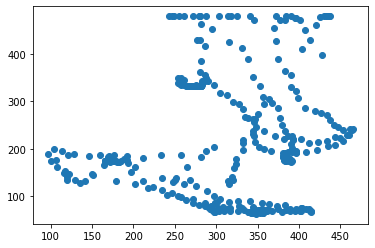

In [221]:
plt.scatter(pts_dst[:,0],pts_dst[:,1])


In [232]:
dis = lambda x : np.sqrt(x[0]**2 + x[1]**2 )
m = np.mean(bbox1_train,axis=0)
q = np.quantile([dis(arr)-dis(m) for arr in bbox1_train],0.75)
inters2 = [i for i in range(len(bbox1_train)) if (dis(bbox1_train[i])-dis(m)) < q]
bbox1_train = np.array(bbox1_train)[np.array(inters2),:]
bbox2_train = np.array(bbox2_train)[np.array(inters2),:]



In [233]:
pts_src_trunc = np.append(np.array([arr[:2] for arr in bbox1_train]),np.array([arr[2:] for arr in bbox1_train]),axis=0)
pts_dst_trunc = np.append(np.array([arr[:2] for arr in bbox2_train]),np.array([arr[2:] for arr in bbox2_train]),axis=0)



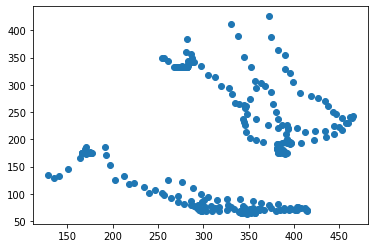

In [234]:
plt.scatter(pts_dst_trunc[:,0],pts_dst_trunc[:,1])

In [ ]:
experiment_dst = np.array([arr for arr in pts_dst if arr is not None ])
m_dst = np.mean(experiment_dst,axis=0)
plt.scatter((experiment_dst)[:,0],(experiment_dst)[:,1])

In [ ]:
experiment_src = np.array([arr for arr in pts_src if arr is not None ])
m_src = np.mean(experiment_src,axis=0)
plt.scatter((experiment_src)[:,0],(experiment_src)[:,1])

In [ ]:
dis = lambda x : np.sqrt(x[0]**2 + x[1]**2 )
q = np.quantile([dis(arr) for arr in experiment],0.75)
inters2 = [i for i in range(len(experiment)) if dis(experiment[i]) < q]
pts_src = experiment[np.array(inters2)]
# pts_dst = experiment[np.array(inters2)]


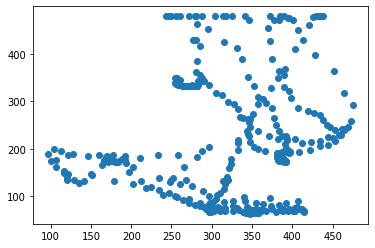

In [178]:
experiment_dst = np.array([arr for arr in pts_dst if arr is not None ])
m_dst = np.mean(experiment_dst,axis=0)
plt.scatter((experiment_dst)[:,0],(experiment_dst)[:,1])

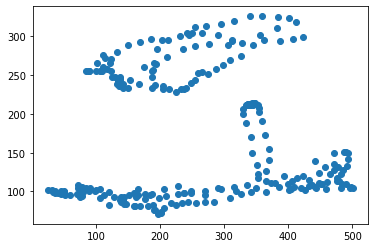

In [179]:
experiment_src = np.array([arr for arr in pts_src if arr is not None ])
m_src = np.mean(experiment_src,axis=0)
plt.scatter((experiment_src)[:,0],(experiment_src)[:,1])

100.33441776303098

In [593]:
#does more data helps linear reg

data = 20
x1 = range(15,50)
x2 = range(1,10)

x = np.array([[np.random.choice(x1),np.random.choice(x2)] for i in range(data)])
y = np.dot(x,[0.4,2]) + np.random.normal(size = data)


coef = np.dot(np.linalg.inv(np.dot(x.T,x)), np.dot(x.T,y))

In [594]:
coef

array([0.38280504, 2.05589735])

In [595]:
np.dot(x.T,x)

array([[22413,  2967],
       [ 2967,   560]])

In [596]:
np.linalg.inv(np.dot(x.T,x))

array([[ 0.00014941, -0.00079158],
       [-0.00079158,  0.00597968]])

In [597]:
np.dot(x.T,y)

array([14679.65678319,  2287.08506695])

# To simulate building occupancy 

In [22]:
import cv2
from matplotlib import pyplot as plt 
import numpy as np
im = cv2.imread('/home/chunhung/Downloads/NUH_MB_English_Level_2.jpg')
im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

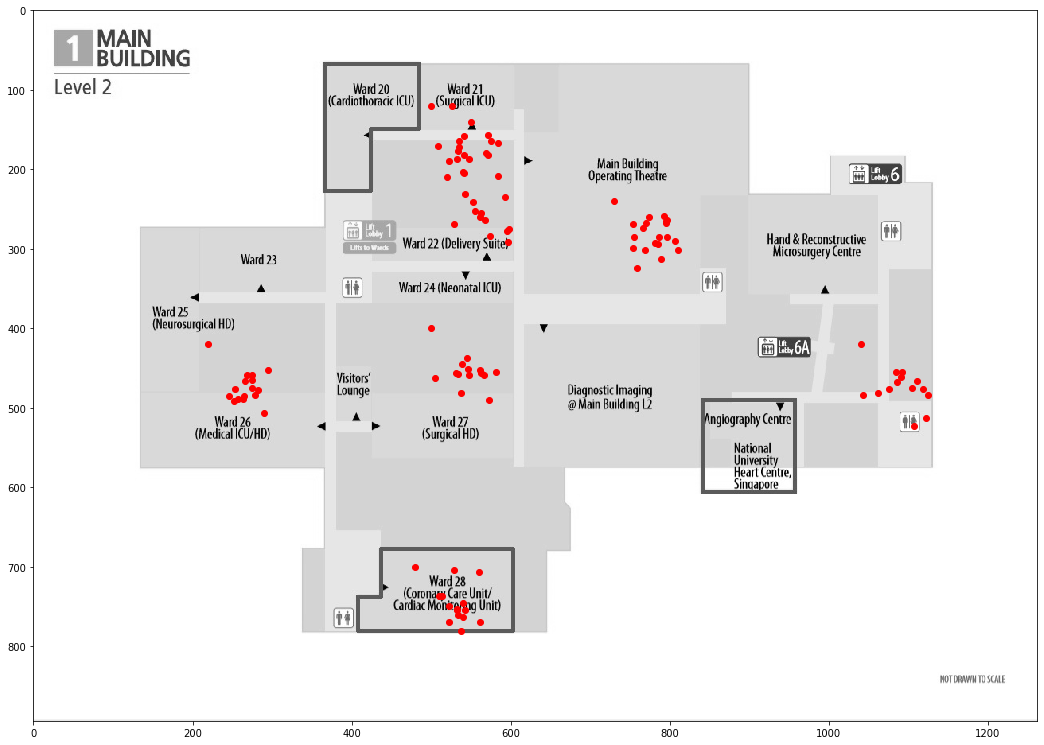

In [101]:
plt.figure(figsize=(18,18))
plt.imshow(im,cmap='gray')

centroid = np.array([[500,120],[520,210],[730,240],[500,400],[480,700],[220,420],[1040,420]])
all_pts = centroid[:]
for c in centroid:
    x_sto = [np.random.normal(50,20) for i in range(20)]
    y_sto = [np.random.normal(50,20) for i in range(20)]    
    choose = np.random.choice(list(range(12,20)))
    x_sto = x_sto[:choose]
    y_sto = y_sto[:choose]    
    all_pts = np.append(all_pts ,np.append(np.expand_dims(np.array(x_sto) + c[0],axis=1),np.expand_dims(np.array(y_sto) + c[1],axis=1),axis=1),axis=0)
    
plt.scatter(all_pts[:,0],all_pts[:,1],color='red')

# harris corner detection

In [5]:
cam1 = cv2.imread('feeds/lab/cam1/000000/000021.jpg')
cam2 = cv2.imread('feeds/lab/cam4/000000/000021.jpg')
gray = cv2.cvtColor(cam1,cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(cam2,cv2.COLOR_BGR2GRAY)

In [6]:
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,3,3,0.04)

In [7]:
dst = cv2.dilate(dst,None)

In [8]:
cam1[dst>0.01*dst.max()]=[0,0,255]

In [9]:
cv2.imshow('dst',cam1)
if cv2.waitKey(0) & 0xff == ord('q'):
    cv2.destroyAllWindows()

# ransac

In [94]:
x = np.arange(0,100)
x = [np.random.choice(x) for i in range(60)]
a = 0.4
interc = 20
error = [np.random.normal(5,20) for i in range(len(x))]

y = np.array(x)*a + error + interc

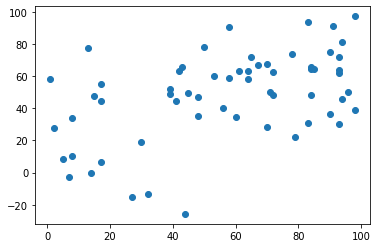

In [95]:
plt.scatter(x,y)

/home/chunhung/.local/share/virtualenvs/tracking-OvMsObDy/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/home/chunhung/.local/share/virtualenvs/tracking-OvMsObDy/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


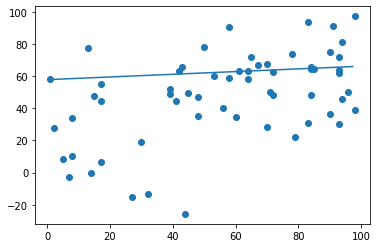

In [96]:
eps = 3
l = list(range(0,len(x)))
most_neig = 0

plt.ion()
for i in range(30):
    ax.cla()
    subset = []
    #pick 2 pts
    pick = []
    for rep in range(2):
        pick += [np.random.choice(l)]
        l.pop(l.index(pick[-1]))

    x_pts = [x[pick[0]],x[pick[1]]]
    y_pts = [y[pick[0]],y[pick[1]]]
    b = (y_pts[1] - y_pts[0])/(x_pts[1] - x_pts[0]) + 0.001
    c = y_pts[1] - b*x_pts[1]
    
    for ind in l:
        if abs(y[ind] - b*x[ind] -c ) <= eps:
            subset += [[x[ind],y[ind]]]
    if len(subset) > most_neig:
        most_neig = len(subset)
        targ = [b,c,len(subset)]
    


plot_y = [min(x)*targ[0] + targ[1], max(x)*targ[0] + targ[1]]

ax = plt.subplot()
ax.scatter(x,y)
ax.plot([min(x),max(y)],plot_y)

In [97]:
targ

[0.08329738316612927, 57.877902057890644, 8]

# harris corner

In [253]:
I = np.array([[5,10],[10,11]])
np.linalg.eig(I)

(array([-2.44030651, 18.44030651]),
 array([[-0.80229293, -0.59693053],
        [ 0.59693053, -0.80229293]]))

In [257]:
x = [[np.random.normal(3)] for i in range(20)]
y = [[np.random.normal(3)] for i in range(20)]

pts = np.append(x,y,axis=1)
trans_pts = []
for arr in pts:
    trans_pts += [np.dot(I,arr)]
trans_pts = np.array(trans_pts)

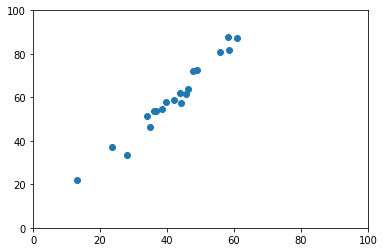

In [258]:
plt.ylim((0,100))
plt.xlim((0,100))
plt.scatter(trans_pts[:,0],trans_pts[:,1])

In [260]:
np.cov(trans_pts[:,0],trans_pts[:,1])

array([[145.4084579 , 207.97856281],
       [207.97856281, 307.90141275]])

In [261]:
np.linalg.eig(np.cov(trans_pts[:,0],trans_pts[:,1]))

(array([  3.37020078, 449.93966987]),
 array([[-0.82579337, -0.56397279],
        [ 0.56397279, -0.82579337]]))

# Distort image

In [94]:
choc = cv2.imread('/home/chunhung/tracking/white_choc_stitch.jpg')
choc = cv2.cvtColor(choc,cv2.COLOR_BGR2RGB)
choc = cv2.resize(choc,(300,300))

In [119]:
k = [0.1 ,2,1,0.4,2,0.4]

def distort(im,k):
    
    

    size = im.shape
    new_frame = np.zeros((size[0],size[1],3))
    #new_frame = np.zeros((int(2*(np.sqrt((size[0]/2)**2 + size[1]/2)**2 + 5)) , int(2*(np.sqrt((size[0]/2)**2 + size[1]/2)**2 +5)),3))
    for i in range(len(im)):
        
        for j in range(len(im[i])):
            try:
                r = i**2 + j**2
                p = (1 + k[0]*(r**2) + k[1]*(r**4) + k[2]*(r**6))
                q = (1 + k[3]*(r**2) + k[4]*(r**4) + k[5]*(r**6))
                new_coord_i = i * (p/q)
                new_coord_j = j * (p/q)
                new_frame[int(new_coord_i),int(new_coord_j),:] = im[i][j]
            except:
                pass


    return new_frame.astype('uint8')

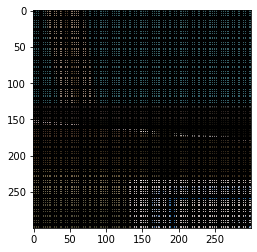

In [120]:
plt.imshow(distort(choc,k))